In [1]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os
import umap
import datashader as ds
import colorcet as cc
import igraph
import tqdm
import pandas as pd
from sklearn.neighbors import NearestNeighbors

from dredFISH.Analysis import TissueGraph
from dredFISH.Visualization import Viz
from dredFISH.Utils.__init__plots import * 
from dredFISH.Utils import powerplots
import importlib
importlib.reload(Viz)
importlib.reload(TissueGraph)

<module 'dredFISH.Analysis.TissueGraph' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Analysis/TissueGraph.py'>

#### Load data

In [2]:
respath = '/bigstore/GeneralStorage/fangming/projects/dredfish/figures/'

In [3]:
basepth = '/bigstore/GeneralStorage/Data/dredFISH/Dataset1'
!ls -alhtr $basepth
!head $basepth"/TMG.json"

total 108M
-rw-r--r-- 1 zach     wollmanlab  16M Jun  9 14:55 DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_matrix.csv
-rw-r--r-- 1 zach     wollmanlab  20M Jun  9 14:55 DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_metadata.csv
-rw-rw-r-- 1 rwollman wollmanlab  165 Jul  7 16:00 TMG.json
-rw-r--r-- 1 fangming wollmanlab  40M Jul  7 16:00 cell.h5ad
-rw-r--r-- 1 fangming wollmanlab 6.8M Jul  7 16:00 isozone.h5ad
-rw-rw-r-- 1 rwollman wollmanlab 647K Jul  7 16:00 region.h5ad
-rw-r--r-- 1 fangming wollmanlab    3 Jul  7 16:00 Taxonomy_clusters.csv
-rw-r--r-- 1 fangming wollmanlab    3 Jul  7 16:00 Taxonomy_topics.csv
drwxrwxrwx 7 zach     wollmanlab 4.0K Jul  8 12:44 ..
drwxrwxr-x 2 rwollman wollmanlab 4.0K Jul 14 14:17 .
-rw-r--r-- 1 fangming wollmanlab  27M Jul 14 14:19 analysis_dev.csv
{"layers_graph": [[0, 1], [0, 2]], "layer_taxonomy_mapping": {"0": 0, "1": 0, "2": 1}, "Taxonomies": ["clusters", "topics"], "Layers": ["cell", "isozone", "region"]}

In [4]:
df = pd.read_csv(
    os.path.join(basepth, "analysis_dev.csv"))
df

,Unnamed: 0,x,y,umap_x,umap_y,b0,b1,b2,b3,b4,...,type_r0.01,type_r0.02,type_r0.05,type_r0.1,type_r0.2,type_r0.5,type_r1,type_r2,type_r5,type_r10
0,0,1911.666962,-1749.638192,-1.901928,-2.967294,-0.603849,1.714861,0.594060,0.139496,1.509942,...,t1,t1,t1,t3,t2,t5,t8,t14,t42,t35
1,1,1850.678429,-1747.172043,-1.789862,-2.849200,-0.530279,1.681959,1.301185,-0.464006,1.570054,...,t1,t1,t1,t3,t2,t5,t8,t14,t42,t35
2,2,1515.123295,-1746.940031,0.184749,0.178933,-0.603849,-0.362498,0.620053,-1.128423,1.206578,...,t1,t1,t1,t3,t2,t5,t10,t4,t34,t61
3,3,1426.161788,-1748.456394,-0.917661,0.854812,-0.298989,1.023065,1.517082,-0.341796,0.475449,...,t1,t1,t1,t3,t2,t4,t10,t4,t53,t63
4,4,1739.792930,-1749.407386,2.384448,-0.265512,-0.603849,-1.351786,1.025515,-1.128423,0.327118,...,t1,t1,t1,t1,t1,t1,t6,t3,t19,t13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77841,77841,-2188.756848,-1084.480934,-4.423579,4.242474,-0.603849,-0.271399,-0.666686,0.269214,0.821624,...,t1,t1,t1,t3,t2,t8,t12,t24,t60,t60
77842,77842,-2257.822983,-1083.270665,-5.205501,5.288445,0.936062,0.386319,-0.614982,1.752306,0.067531,...,t1,t1,t3,t4,t6,t8,t12,t7,t3,t1
77843,77843,-2475.320577,-1083.995803,-5.016026,4.596395,-0.603849,-0.228163,-0.612215,0.895132,0.247026,...,t1,t1,t2,t2,t5,t7,t7,t25,t48,t48
77844,77844,-2311.578984,-1086.717336,1.987716,0.121741,-0.603849,-1.153599,0.699586,-0.204732,1.546018,...,t1,t1,t1,t1,t1,t1,t6,t6,t50,t108


In [5]:
TMG = TissueGraph.TissueMultiGraph(basepath=basepth, 
                                   redo=False, # load existing 
                                  )
TMG

/bigstore/GeneralStorage/Data/dredFISH/Dataset1/cell.h5ad
/bigstore/GeneralStorage/Data/dredFISH/Dataset1/isozone.h5ad
/bigstore/GeneralStorage/Data/dredFISH/Dataset1/region.h5ad


In [6]:
# spatial coordinates
layer = TMG.Layers[0]
XY = layer.XY
x, y = XY[:,0], XY[:,1]
###
x, y = y, x # a temporary hack
###

N = layer.N
print(N)
# measured basis
ftrs_mat = TMG.Layers[0].feature_mat

# umap_mat = umap.UMAP(n_neighbors=30, min_dist=0.1).fit_transform(ftrs_mat)

# types

# regions

77846


# Local env (Isozones)
- same cell type zones
- instead quantify the nearest neighbors of the same cell type

In [7]:
# call isozones
# compare the properties of isozone for each cell type
hue = 'type_r0.1'
labels = df[hue].values
labels

array(['t3', 't3', 't3', ..., 't2', 't1', 't4'], dtype=object)

In [8]:
# isozone
EL = np.asarray(layer.SG.get_edgelist())
EL_types = labels[EL]
EL_sametypes = EL[EL_types[:,0] == EL_types[:,1]]

IsoZoneG = igraph.Graph(n=N, edges=EL_sametypes, directed=False)
IsoZOneG = IsoZoneG.as_undirected().simplify() # what this means?
cmp = IsoZoneG.components()
Ix = np.asarray(cmp.membership)

isozones = Ix

In [9]:
labels, isozones

(array(['t3', 't3', 't3', ..., 't2', 't1', 't4'], dtype=object),
 array([   0,    1,    0, ..., 8419, 1695,   37]))

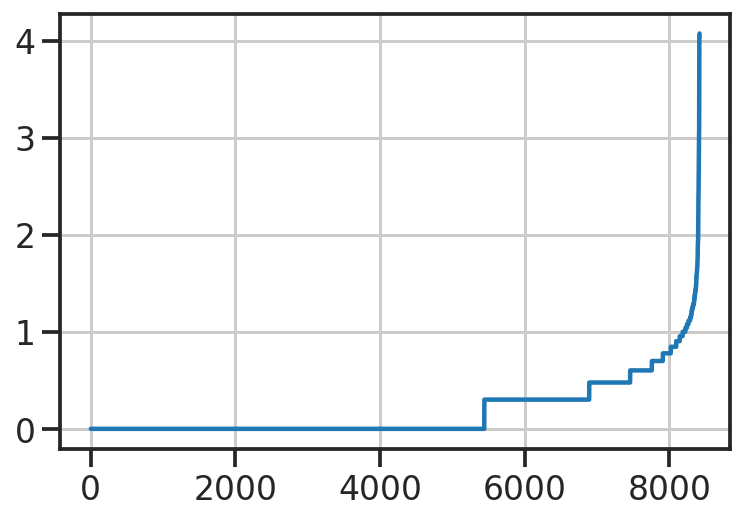

In [10]:
# Ix.shape
unq, cnts = np.unique(Ix, return_counts=True)
plt.plot(np.log10(np.sort(cnts)))

Text(0, 0.5, 'CDF - Num. Isozones or Cells')

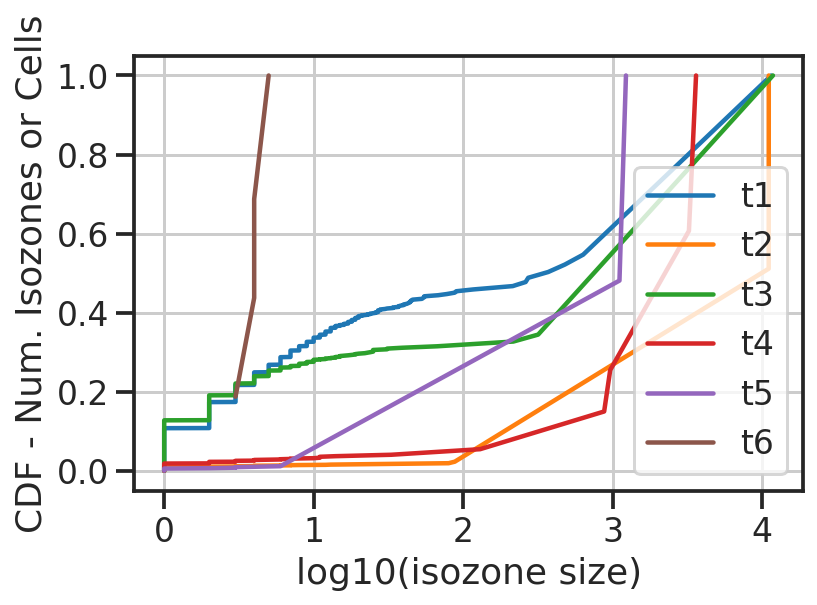

In [11]:

uniqlabels = np.sort(np.unique(labels))
for i in uniqlabels:
    subIso = isozones[labels==i]
    unq, cnts = np.unique(subIso, return_counts=True)
    # plt.plot(np.log10(np.sort(cnts)), np.linspace(0, 1, len(cnts)), label=i)
    _x = np.cumsum(np.sort(cnts))
    plt.plot(np.log10(np.sort(cnts)), _x/_x[-1], label=i)
    # plt.plot(np.sort(cnts), np.linspace(0, 1, len(cnts)), label=i)
plt.legend()
plt.xlabel('log10(isozone size)')
plt.ylabel('CDF - Num. Isozones or Cells')
    

## Spatial nearest neighbors 
- distance to the nearest neighbors
- dependencies between cell types?


- the critical scale at which cells talk to each other?

In [12]:
%%time
# slow for 24 bits; fast for 2D
k = 30 
NN = NearestNeighbors(n_neighbors=k)
NN.fit(XY)
knn = NN.kneighbors(XY, return_distance=False)

knn
# use pynndescent

CPU times: user 410 ms, sys: 364 ms, total: 774 ms
Wall time: 774 ms


array([[    0, 68289, 68290, ..., 31395,    66, 31398],
       [    1,     9, 68295, ..., 68233, 68214,    84],
       [    2,     7,    18, ..., 68260,    50,    30],
       ...,
       [77843, 77838, 77824, ..., 15428, 15496, 15437],
       [77844, 77840, 77834, ..., 15441, 15432, 77833],
       [77845, 15428, 15440, ..., 15490, 77800, 77824]])

In [13]:
fracs = (labels.reshape(-1,1) == labels[knn[:,1:]]).sum(axis=1)/k

In [15]:
x = df['x'].values
y = df['y'].values
knn1 = knn[:,1]
dists = np.sqrt(np.power(x[knn1] - x, 2) + np.power(y[knn1] - y, 2))
dists


array([ 4.2199955 , 17.59880531, 10.92874117, ...,  7.91066168,
        8.71282096, 19.25145463])

Text(0, 0.5, 'CDF - Num. cells')

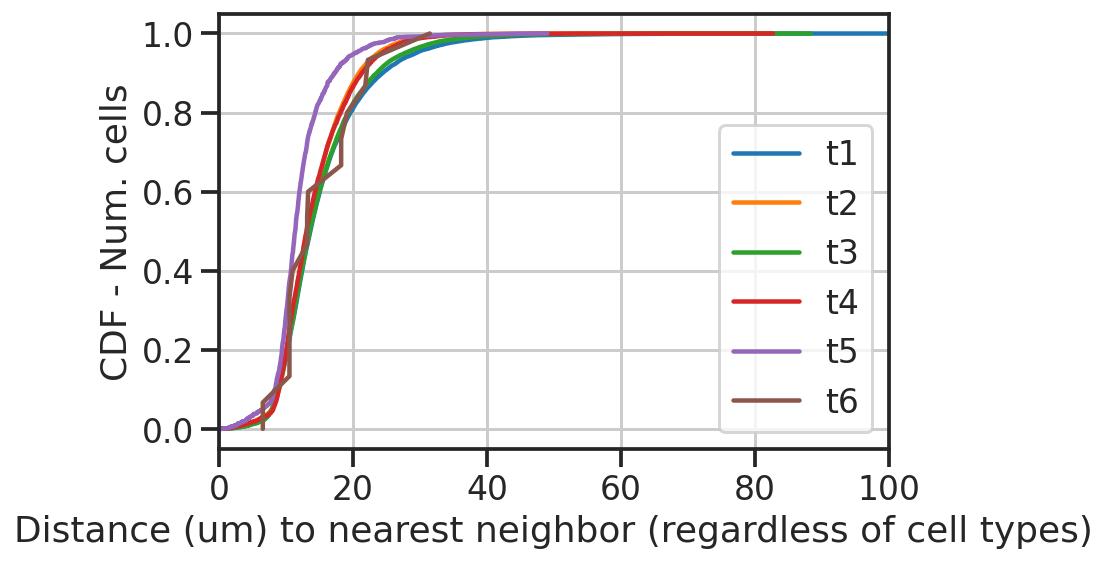

In [17]:
uniqlabels = np.sort(np.unique(labels))
for i in uniqlabels:
    sub_dists = dists[labels==i]
    plt.plot(np.sort(sub_dists), np.linspace(0, 1, len(sub_dists)), label=i)
plt.xlim([0,100])
plt.legend()
plt.xlabel('Distance (um) to nearest neighbor (regardless of cell types)')
plt.ylabel('CDF - Num. cells')
    

Text(0, 0.5, 'CDF - Num. cells')

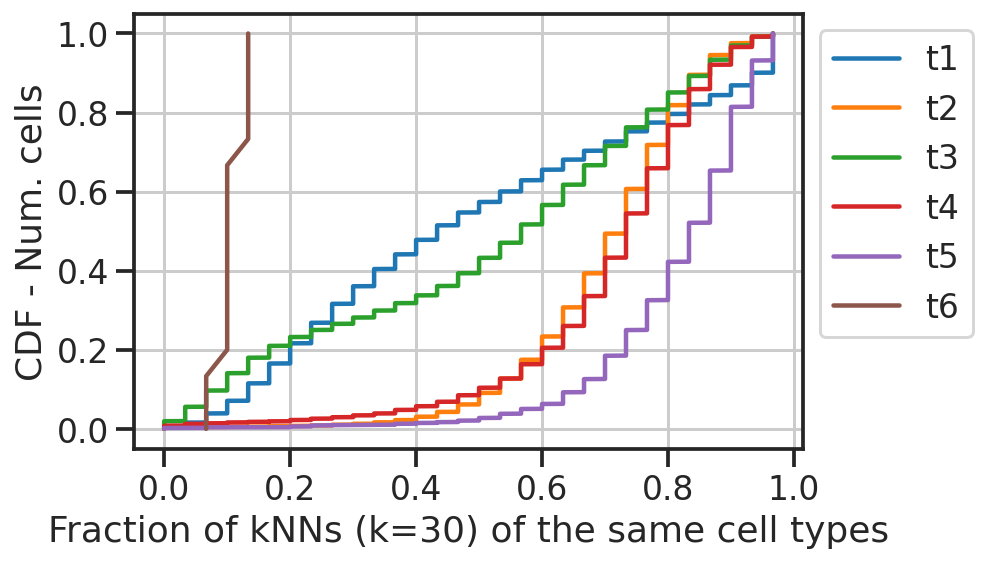

In [20]:
uniqlabels = np.sort(np.unique(labels))
for i in uniqlabels:
    sub_fracs = fracs[labels==i]
    plt.plot(np.sort(sub_fracs), np.linspace(0, 1, len(sub_fracs)), label=i)
# plt.xlim([0,100])
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Fraction of kNNs (k=30) of the same cell types')
plt.ylabel('CDF - Num. cells')
    

# Local env (Brain regions)